In [60]:
"""
以下为绘制一颗二叉树
"""

import matplotlib.pyplot as plt
import pickle

In [114]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")# 绘制文本框和箭头样式
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="->")

# plotNode

plotNode绘制带注解的箭头，由于决策树绘制时需要内嵌带箭头的划线工具，可以从父节点指向数据位置，并在数据位置添加描述信息。

plotNode需要四个参数，描述信息、数据位置、父节点位置和节点类型。

节点类型包括决策点和结果点，不同结点类型的绘制标签不一样。

arrowstyle为划线样式，当前为$->$，可以为其他类型不过要参照文档，不能自定义。

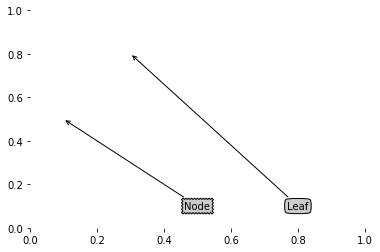

In [111]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',
                           va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
    plt.rcParams['axes.unicode_minus'] = False 
    fig.clf()
    createPlot.ax1  = plt.subplot(111, frameon=False)
    plotNode("Node", (0.5,0.1), (0.1,0.5), decisionNode)
    plotNode('Leaf', (0.8,0.1), (0.3,0.8), leafNode)
    plt.show()

createPlot()

In [94]:
def getNumLeafs(myTree): # 获取叶子数
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):  # 获取决策树深度
    maxDepth = 0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

# 绘制决策树图像
绘制原理也很简单，就是给定一个初始位置作为根节点，决策树绘制时要保证各个节点之间的动态距离所以要知道决策树深度和宽度。

深度好理解，就是决策树的层数，而宽度没法直接获取而用叶子数间接表示。

绘制图时首先绘制根节点，然后计算子节点的位置，计算方法如下：

plotTree.xOff用来保存当前节点的横坐标

plotTree.yOff用来保存当前节点的纵坐标

plotTree.totalW是树的宽度

plotTree.totalD是树的深度

计算当前节点位置：
进入函数是决策节点，所以横坐标位置为之前横坐标的值加上当前树的宽度除以２再除以树的宽度，为什么要这么算呢?
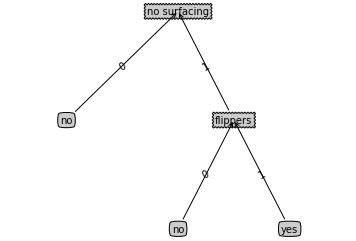

参考上面的图会发现子节点的横坐标是父节点横坐标加上子节点树的宽度除以２,如何算子树的宽度呢？子树的宽度是一个动态变化的值。 1+float(numLeafs)代表当前子树需要绘制的宽度(1代表根节点),为什么要除以总树的宽度呢，是因为要对子树的实际长度进行一下放缩，如果不放缩就会导致子树之间互相覆盖，这就是子树根节点横坐标的计算方式。

细心的朋友还会发现在绘制决策点是没有改变plotTree.xOff的值，但是在叶子节点上却修改了，这是为什么呢。可以假设一下改变会发生什么，如果决策点改变的话，那么子节点的坐标都会在叶子节点右边，现在可以看出其实plotTree.xOff代表当前叶子节点横坐标最新的参考值，其他点都需要参考值得到当前点的位置。

In [141]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString): # 计算父节点和子节点的中心位置，添加文本信息即0或１
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on  深度优先遍历
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)  #计算当前节点的位置
    plotMidText(cntrPt, parentPt, nodeTxt) 
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():  # 递归绘制图形
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [142]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW 
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()